# Integrate scRNA-seq and CODEX data from bone marrow tissue for cell subtype prediction

In [1]:
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np
from cellink import Cellink
from cellink.utils import *

/Users/luosanj/opt/anaconda3/envs/CelLink/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read scRNA-seq and CODEX datasets

In [34]:
scRNA = pd.read_csv('/Users/luosanj/Desktop/project2/data/Human_bone_marrow_normal/scrna_count.csv')
CODEX = pd.read_csv('/Users/luosanj/Desktop/project2/data/Human_bone_marrow_normal/codex_count.csv')
scRNA_meta = pd.read_csv('/Users/luosanj/Desktop/project2/data/Human_bone_marrow_normal/scrna_metadata.csv')
CODEX_meta = pd.read_csv('/Users/luosanj/Desktop/project2/data/Human_bone_marrow_normal/metadata.csv')

In [35]:
rna_feature = scRNA.iloc[:,0]
rna_obs = scRNA.columns[1:]
rna_mat = scRNA.iloc[:, 1:].to_numpy().T
# convert to anndata
rna_adata = ad.AnnData(rna_mat, dtype = np.float32)
rna_adata.var_names = rna_feature
rna_adata.obs_names = rna_obs

rna_adata.obs['cell_type'] = scRNA_meta['cluster_anno_coarse'].values
#rna_adata.obs['cell_type'] = scRNA_meta['cluster_anno_l2'].values
rna_adata.obs['cell_subtype'] = scRNA_meta['cluster_anno_l2'].values

/Users/luosanj/opt/anaconda3/envs/CelLink/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [36]:
protein_feature = CODEX.iloc[:,0]
protein_obs = CODEX.columns[1:]
protein_mat = CODEX.iloc[:, 1:].to_numpy().T
# convert to anndata
protein_adata = ad.AnnData(protein_mat, dtype = np.float32)
protein_adata.var_names = protein_feature
protein_adata.obs_names = protein_obs

protein_adata.obs['cell_type'] = CODEX_meta['cluster_anno_coarse'].values
protein_adata.obs['cell_subtype'] = CODEX_meta['cluster_anno_l2'].values

/Users/luosanj/opt/anaconda3/envs/CelLink/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [37]:
protein_adata.obs['cell_type'].value_counts()

cell_type
Lymphoid       5621
Monocytes      2105
Macrophages    1321
MSC             617
HSPC            200
VSMC            136
Name: count, dtype: int64

In [38]:
protein_adata.obsm['spatial'] = pd.DataFrame(CODEX_meta[['x.coord', 'y.coord']].values, index = protein_adata.obs_names, columns = ['X', 'Y'])

# Data preprocessing

In [39]:
# # process all RNA features
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.highly_variable_genes(rna_adata, n_top_genes=10000)
# # only retain highly variable genes
rna_adata1 = rna_adata[:, rna_adata.var.highly_variable].copy()

if 'CD34' not in rna_adata1.var_names:
    # Extract the CD34 gene expression data from rna_adata
    cd34_data = rna_adata[:, 'CD34'].X
    
    # Create a new AnnData object with CD34 data
    cd34_adata = ad.AnnData(X=cd34_data, var=pd.DataFrame(index=['CD34']), obs=rna_adata1.obs)
    
    # Concatenate the CD34 data with rna_adata1 along the genes axis (columns)
    rna_adata1 = ad.concat([rna_adata1, cd34_adata], axis=1)
    
rna_adata1.obs = rna_adata.obs

/Users/luosanj/opt/anaconda3/envs/CelLink/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/Users/luosanj/opt/anaconda3/envs/CelLink/lib/python3.9/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding
/Users/luosanj/opt/anaconda3/envs/CelLink/lib/python3.9/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding
/Users/luosanj/opt/anaconda3/envs/CelLink/lib/python3.9/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).a

### Align cell lineage and cell subtypes between two datasets. 

#### Labels used to judge whether cells are successfully matched are stored in .obs['cell_type'] of the AnnData.

In [40]:
def map_cell_types(cell_type):
    if cell_type in ['Adipo-MSC', 'THY1+ MSC']:
        return 'Mesenchymal'
    elif cell_type in ['VSMC']:
        return 'Muscle'
    elif cell_type in ['GMP', 'Monocytes', 'Monocyte', 'Macrophages']:
        return 'Myeloid'
    elif cell_type in ['CD8+ T-Cell', 'CD4+ T-Cell', 'Plasma Cell', 'Plasma Cells', 'CLP']:
        return 'Lymphoid'
    else:
        return cell_type

rna_adata1.obs['cell_type'] = rna_adata1.obs['cell_subtype'].apply(map_cell_types)
protein_adata.obs['cell_type'] = protein_adata.obs['cell_subtype'].apply(map_cell_types)

In [41]:
def map_cell_types(cell_type):
    if cell_type in ['Monocytes']:
        return 'Monocyte'
    elif cell_type in ['Plasma Cells']:
        return 'Plasma Cell'
    else:
        return cell_type

rna_adata1.obs['cell_subtype'] = rna_adata.obs['cell_subtype'].apply(map_cell_types)
protein_adata.obs['cell_subtype'] = protein_adata.obs['cell_subtype'].apply(map_cell_types)

## Extract linked features

In [42]:
correspondence = pd.read_csv('/Users/luosanj/Desktop/project2/data/Human_bone_marrow_normal/protein_gene_mapping_expanded.csv')

In [43]:
rna_protein_correspondence = []
for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata1.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])
            
rna_protein_correspondence = np.array(rna_protein_correspondence)

In [44]:
rna_adata1.obs['cell_subtype'].value_counts()

cell_subtype
Plasma Cell    4249
Adipo-MSC      1398
THY1+ MSC      1131
GMP             895
VSMC            815
CD4+ T-Cell     674
CD8+ T-Cell     425
Monocyte        335
Macrophages      78
Name: count, dtype: int64

In [31]:
# correspondence information
protein_adata.var_names_make_unique()
rna_shared = rna_adata1[:, rna_protein_correspondence[:, 0]].copy()
protein_shared = protein_adata[:, rna_protein_correspondence[:, 1]].copy()

/Users/luosanj/opt/anaconda3/envs/CelLink/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/luosanj/opt/anaconda3/envs/CelLink/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [49]:
# Make sure no column is static
mask = (
    (rna_shared.X.std(axis=0) > 0.1) 
    & (protein_shared.X.std(axis=0) > 0.1)
)
mask[np.where(rna_shared.var_names == "CD8B")[0][0]] = True
mask[np.where(protein_shared.var_names == "CD163")[0][0]] = True
mask[np.where(protein_shared.var_names == "CD34")[0][0]] = True
rna_shared = rna_shared[:, mask].copy()
protein_shared = protein_shared[:, mask].copy()
print([rna_shared.shape,protein_shared.shape])

[(10000, 39), (10000, 39)]


/Users/luosanj/opt/anaconda3/envs/CelLink/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/luosanj/opt/anaconda3/envs/CelLink/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [18]:
# rna_adata1.write_h5ad('/Users/luosanj/Desktop/project2/data/Human_bone_marrow_normal/rna_adata.h5ad')
# protein_adata.write_h5ad('/Users/luosanj/Desktop/project2/data/Human_bone_marrow_normal/protein_adata.h5ad')
# rna_shared.write_h5ad('/Users/luosanj/Desktop/project2/data/Human_bone_marrow_normal/rna_shared.h5ad')
# protein_shared.write_h5ad('/Users/luosanj/Desktop/project2/data/Human_bone_marrow_normal/protein_shared.h5ad')

In [46]:
rna_adata1 = sc.read_h5ad('/Users/luosanj/Desktop/project2/data/Human_bone_marrow_normal/rna_adata.h5ad')
protein_adata = sc.read_h5ad('/Users/luosanj/Desktop/project2/data/Human_bone_marrow_normal/protein_adata.h5ad')
rna_shared = sc.read_h5ad('/Users/luosanj/Desktop/project2/data/Human_bone_marrow_normal/rna_shared.h5ad')
protein_shared = sc.read_h5ad('/Users/luosanj/Desktop/project2/data/Human_bone_marrow_normal/protein_shared.h5ad')

/Users/luosanj/opt/anaconda3/envs/CelLink/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/luosanj/opt/anaconda3/envs/CelLink/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
rna_adata1.obs['cell_subtype'].value_counts()

cell_subtype
Plasma Cell    4249
Adipo-MSC      1398
THY1+ MSC      1131
GMP             895
VSMC            815
CD4+ T-Cell     674
CD8+ T-Cell     425
Monocyte        335
Macrophages      78
Name: count, dtype: int64

In [13]:
protein_adata.obs['cell_subtype'].value_counts()

cell_subtype
Monocyte       2105
CD4+ T-Cell    2065
Plasma Cell    1791
CD8+ T-Cell    1765
Macrophages    1321
Adipo-MSC       336
THY1+ MSC       281
GMP             200
VSMC            136
Name: count, dtype: int64

## Start integtation

In [37]:
arr = [rna_shared, protein_shared]
cellink = Cellink(full_ann1 = rna_adata1, full_ann2 = protein_adata, shared_ann1 = rna_shared, shared_ann2 = protein_shared)
cellink.split_into_batches(arr, 10000, seed = 100)

Cell annotations are provided. Perform Iteratively OT!
The first modality is split into 1 batches, and max batch size is 10000.
The second modality is split into 1 batches, and max batch size is 10000.
Batch to batch correspondence is:
  ['0<->0'].


In [38]:
cellink.alignment(wt1 = 0.3, wt2 = 0.3, numItermax = 1000, reg = 0.005, 
                  reg_m1 = (40, 0.01), reg_m2 = (0.01, 40), iterative = True, sparse = False, BOT = False)

Now at batch 0<->0...


/Users/luosanj/opt/anaconda3/envs/alignment/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/Users/luosanj/opt/anaconda3/envs/alignment/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:553: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


10000 cells from Modality X are unmatched in Phase I and are realigned in Phase II.
iterative unbalanced optimal transport converges after 7 iterations with cell-type matching accuracy 97.45%! 

There are 255 unmatched samples and 9745 matched samples in data1!
10000 cells from Modality Y are unmatched in Phase I and are realigned in Phase II.
iterative unbalanced optimal transport converges after 5 iterations with cell-type matching accuracy 94.86%! 

There are 514 unmatched samples and 9486 matched samples in data2!


## Cell subtype prediction (label transfer)

In [61]:
ct_anno = []
protein_id = []
for i in range(len(cellink.partition2)):
    cell_id = cellink.partition2[i]
    cell_id_rna = cellink.partition1[i]
    target_cell_types = rna_adata1.obs['cell_subtype'][cell_id_rna] # change into self
    for j in range(len(cell_id)):
        if j not in cellink.arr2_unmatched_cell_id[i]:
            weight_distribution = {}
            for target_cell_type in np.unique(target_cell_types):
                # Find indices of cells in the target dataset belonging to this cell type
                target_indices = np.where(target_cell_types == target_cell_type)[0]
                # Sum the weights in the transport map for these indices
                # This gives the total transport weight directed towards cells of this target cell type
                total_weight = cellink.cell_correspondence_partition2[i][j][target_indices].sum()
                # Store the total weight in the dictionary
                weight_distribution[target_cell_type] = total_weight

            sct = protein_adata.obs['cell_subtype'][cell_id[j]] # change into self
            pct = max(weight_distribution, key = weight_distribution.get)
            ct_anno.append([sct, pct])
            protein_id.append(cell_id[j])
            
ct_anno_df = pd.DataFrame(ct_anno, columns = ['sct', 'pct'])
sub = ct_anno_df.apply(lambda x: x['sct'] == x['pct'], axis=1)
sub.values.sum() / ct_anno_df.shape[0]

/var/folders/zz/067t14gd4nj4836tcg_c5prw0000gt/T/ipykernel_20843/3417148446.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_cell_types = rna_adata1.obs['cell_subtype'][cell_id_rna] # change into self
/var/folders/zz/067t14gd4nj4836tcg_c5prw0000gt/T/ipykernel_20843/3417148446.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sct = protein_adata.obs['cell_subtype'][cell_id[j]] # change into self


0.87202192705039

In [52]:
sub.values.sum()

8272

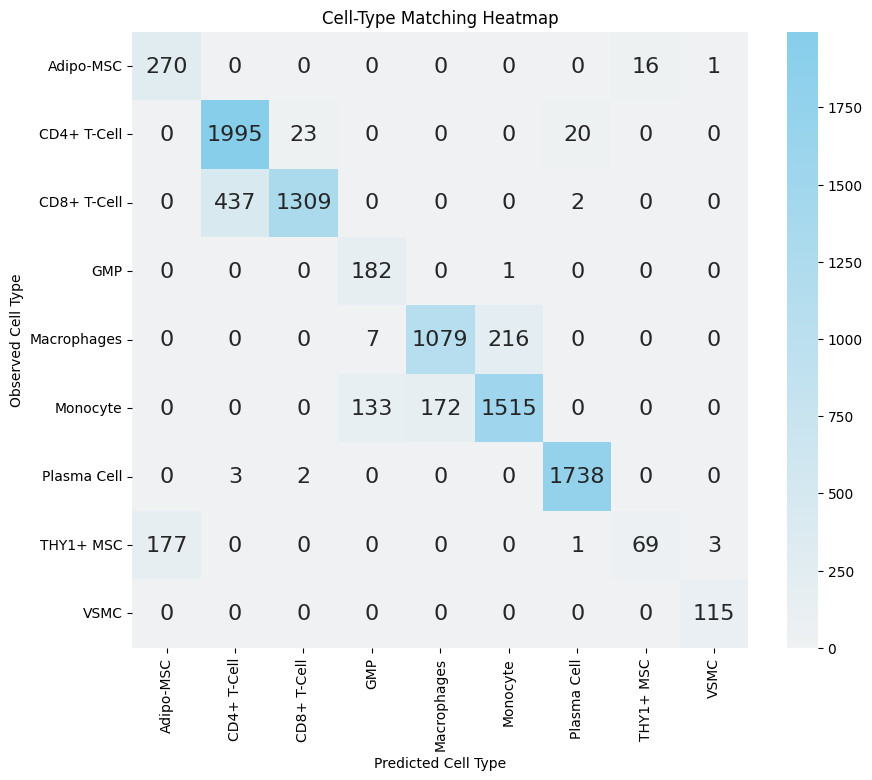

In [53]:
import seaborn as sns
protein_source_ct_array = np.array(ct_anno_df['sct'])
protein_predict_ct_array = np.array(ct_anno_df['pct'])
cross_tab = pd.crosstab(ct_anno_df['sct'], ct_anno_df['pct'])
all_cell_types = sorted(list(set(np.unique(rna_adata1.obs['cell_subtype'].values))))
cross_tab = cross_tab.reindex(index=all_cell_types, columns=all_cell_types, fill_value=0)
# Plotting the heatmap
method_color = 'skyblue'  # CelLink method color
cmap = sns.light_palette(method_color, as_cmap=True)
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, cmap=cmap, annot_kws={"size": 16}, fmt='g', square=True)
plt.title('Cell-Type Matching Heatmap')
plt.xlabel('Predicted Cell Type')
plt.ylabel('Observed Cell Type')
plt.savefig('/Users/luosanj/Desktop/figures/celLink/bm_protein_subtype_heatmap.pdf')
plt.show()

In [54]:
ct_anno = []
rna_id = []
for i in range(len(cellink.partition1)):
    cell_id = cellink.partition1[i]
    cell_id_protein = cellink.partition2[i]
    target_cell_types = protein_adata.obs['cell_subtype'][cell_id_protein] # change into self
    for j in range(len(cell_id)):
        if j not in cellink.arr1_unmatched_cell_id[i]:
            weight_distribution = {}
            for target_cell_type in np.unique(target_cell_types):
                # Find indices of cells in the target dataset belonging to this cell type
                target_indices = np.where(target_cell_types == target_cell_type)[0]
                # Sum the weights in the transport map for these indices
                # This gives the total transport weight directed towards cells of this target cell type
                total_weight = cellink.cell_correspondence_partition1[i][j][target_indices].sum()
                # Store the total weight in the dictionary
                weight_distribution[target_cell_type] = total_weight

            sct = rna_adata1.obs['cell_subtype'][cell_id[j]] # change into self
            pct = max(weight_distribution, key = weight_distribution.get)
            ct_anno.append([sct, pct])
            rna_id.append(cell_id[j])
ct_anno_df = pd.DataFrame(ct_anno, columns = ['sct', 'pct'])
sub = ct_anno_df.apply(lambda x: x['sct'] == x['pct'], axis=1)
sub.values.sum() / ct_anno_df.shape[0]

/var/folders/zz/067t14gd4nj4836tcg_c5prw0000gt/T/ipykernel_20843/2041620325.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_cell_types = protein_adata.obs['cell_subtype'][cell_id_protein] # change into self
/var/folders/zz/067t14gd4nj4836tcg_c5prw0000gt/T/ipykernel_20843/2041620325.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sct = rna_adata1.obs['cell_subtype'][cell_id[j]] # change into self


0.8044125192406362

In [55]:
sub.values.sum()

7839

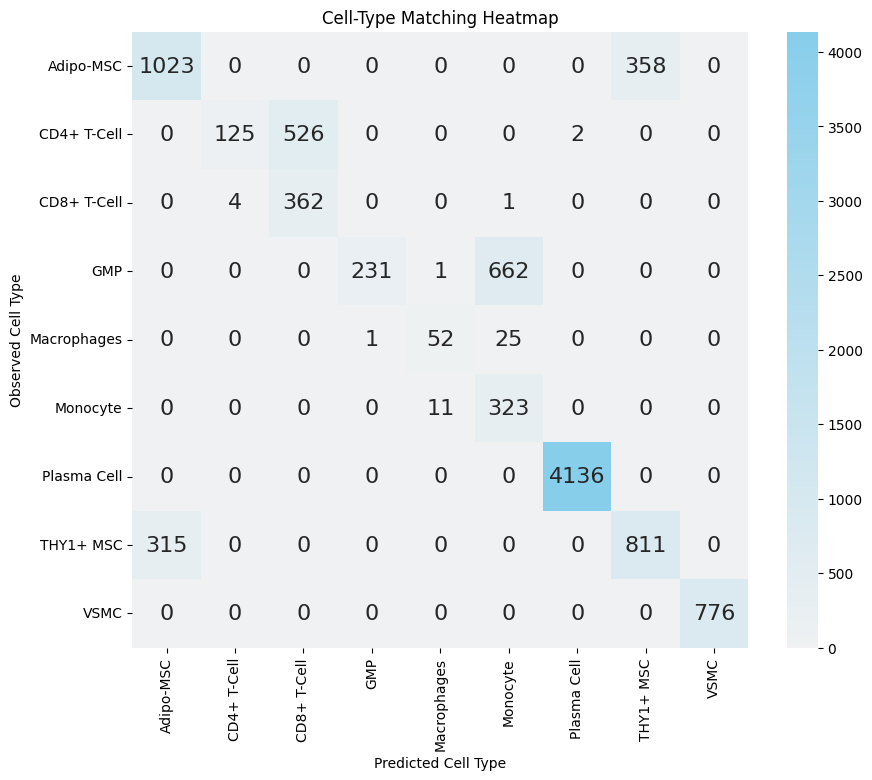

In [56]:
import seaborn as sns
rna_source_ct_array = np.array(ct_anno_df['sct'])
rna_predict_ct_array = np.array(ct_anno_df['pct'])
cross_tab = pd.crosstab(ct_anno_df['sct'], ct_anno_df['pct'])
all_cell_types = sorted(list(set(np.unique(rna_adata1.obs['cell_subtype'].values))))
# Plotting the heatmap
method_color = 'skyblue'  # CelLink method color
cmap = sns.light_palette(method_color, as_cmap=True)
cross_tab = cross_tab.reindex(index=all_cell_types, columns=all_cell_types, fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, cmap=cmap, annot_kws={"size": 16}, fmt='g', square=True)
plt.title('Cell-Type Matching Heatmap')
plt.xlabel('Predicted Cell Type')
plt.ylabel('Observed Cell Type')
plt.savefig('/Users/luosanj/Desktop/figures/celLink/bm_rna_subtype_heatmap.pdf')
plt.show()

## Feature Imputation

In [47]:
rna_source_ct_array = np.zeros(shape = rna_shared.shape[0], dtype = 'object')
rna_predict_ct_array = np.zeros(shape = rna_shared.shape[0], dtype = 'object')
# the cell index of the rna_aligned_protein is not the same as the original cell index, modify the logic by looping cellink.partition1[i] rather than len(rna_batch)
rna_aligned_protein = np.zeros(shape = (rna_adata1.shape[0], protein_adata.shape[1]))
for i in range(len(cellink.partition1)):
    cell_id = cellink.partition1[i]
    match_id = np.array(list(cellink.cell_correspondence_partition1[i].keys()))
    jump_num = 0
    for j in range(len(cell_id)):
        rna_source_ct_array[cell_id[j]] = rna_shared.obs['cell_type'].iloc[cell_id[j]]
        unmatched_cell_id_rna = cellink.arr1_unmatched_cell_id[i]
        if j in unmatched_cell_id_rna:
            rna_predict_ct_array[cell_id[j]] = cellink.arr1_wrong_ct[i][np.where(unmatched_cell_id_rna == j)[0][0]]
            jump_num = jump_num + 1
        else:
            rna_predict_ct_array[cell_id[j]] = rna_shared.obs['cell_type'].iloc[cell_id[j]]
            nid = np.where(match_id == j)[0][0]
            rna_aligned_protein[cell_id[j], :] =  cellink.feature_imputation_partition1[i][nid, :]

protein_source_ct_array = np.zeros(shape = protein_shared.shape[0], dtype = 'object')
protein_predict_ct_array = np.zeros(shape = protein_shared.shape[0], dtype = 'object')
protein_aligned_rna = np.zeros(shape = (protein_adata.shape[0], rna_adata1.shape[1]))
#protein_aligned_rna_full =  np.zeros(shape = (protein_adata.shape[0], rna_adata_all.shape[1]))
for i in range(len(cellink.partition2)):
    cell_id = cellink.partition2[i]
    cell_id_rna = cellink.partition1[0]
    match_id = np.array(list(cellink.cell_correspondence_partition2[i].keys()))
    jump_num = 0
    for j in range(len(cell_id)):
        protein_source_ct_array[cell_id[j]] = protein_shared.obs['cell_type'].iloc[cell_id[j]]
        unmatched_cell_id_protein = cellink.arr2_unmatched_cell_id[i]
        if j in unmatched_cell_id_protein:
            protein_predict_ct_array[cell_id[j]] = cellink.arr2_wrong_ct[i][np.where(unmatched_cell_id_protein == j)[0][0]]
            jump_num += 1
        else:
            protein_predict_ct_array[cell_id[j]] = protein_shared.obs['cell_type'].iloc[cell_id[j]]
            nid = np.where(match_id == j)[0][0]
            protein_aligned_rna[cell_id[j], :] =  cellink.feature_imputation_partition2[i][nid, :]

## Infer joint embeddings

In [48]:
import umap
matched_rna = rna_source_ct_array == rna_predict_ct_array
matched_protein = protein_source_ct_array == protein_predict_ct_array
dataall_0 = np.concatenate([rna_adata1.X, protein_aligned_rna[matched_protein, :]], axis = 0)
embedding_0 = umap.UMAP(n_components=2, n_epochs = 500, n_neighbors = 15, random_state = 30, min_dist = 0.5).fit_transform(dataall_0)
ct_array_double_0 = np.concatenate([rna_source_ct_array, protein_source_ct_array[protein_source_ct_array == protein_predict_ct_array]], axis = 0)

dataall_1 = np.concatenate([protein_adata.X, rna_aligned_protein[matched_rna, :]], axis = 0)
embedding_1 = umap.UMAP(n_components=2, n_epochs = 500, n_neighbors = 15, random_state = 30, min_dist = 0.5).fit_transform(dataall_1)
ct_array_double_1 = np.concatenate([protein_source_ct_array, rna_source_ct_array[rna_source_ct_array == rna_predict_ct_array]], axis = 0)

scrna_all = np.concatenate([rna_adata1[matched_rna].X, rna_aligned_protein[matched_rna]], axis = 1)
codex_all = np.concatenate([protein_aligned_rna[matched_protein], protein_adata[matched_protein].X], axis = 1)

dataall_2 = np.concatenate([scrna_all, codex_all], axis = 0)
embedding_2 = umap.UMAP(n_components=2, n_epochs = 500, n_neighbors = 15, random_state = 30, min_dist = 0.5).fit_transform(dataall_2)
ct_array_double_2 = np.concatenate([rna_source_ct_array[matched_rna], protein_source_ct_array[matched_protein]], axis = 0)

/Users/luosanj/opt/anaconda3/envs/alignment/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/luosanj/opt/anaconda3/envs/alignment/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/luosanj/opt/anaconda3/envs/alignment/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


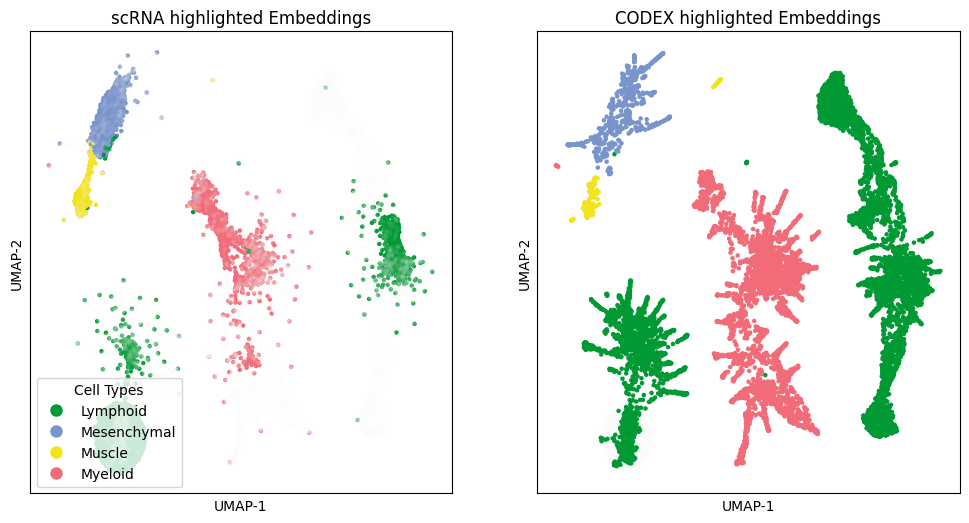

In [49]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
datatype = ['scRNA', 'CODEX']
datatype_array_double = np.concatenate([np.repeat(datatype[0], sum(matched_rna)), np.repeat(datatype[1], sum(matched_protein))], axis = 0)
ct_array1 = rna_adata1[matched_rna,].obs['cell_type'].values
ct_array2 = protein_adata[matched_protein].obs['cell_type'].values 
ct_array_double = np.concatenate([ct_array1, ct_array2], axis = 0)

colorbar = {'Lymphoid': np.array([0, 0.6, 0.2, 1.0]),
 'Mesenchymal': np.array([0.47265625, 0.58203125, 0.796875  , 1.        ]),
 'Muscle': np.array([0.953125 , 0.890625 , 0.1171875, 1.       ]),
 'Myeloid': np.array([0.9453125 , 0.41796875, 0.46875   , 1.        ])}
    
color_points = np.array([colorbar[i] for i in ct_array_double])

dts = np.unique(datatype_array_double)
color_datatype = ["#FFA500", "#004D99"]
colorbardt = {t: color_datatype[i] for i, t in enumerate(dts)}
color_dt = np.array([colorbardt[i] for i in datatype_array_double])

grey = np.array([0.98, 0.98, 0.98, 0.05])[np.newaxis, :]

protein_id = np.array(range(0, len(ct_array1)))
rna_id = np.array(range(len(ct_array1), len(ct_array_double)))
color_points1 = color_points.copy()
color_points1[rna_id, :] = grey
color_points2 = color_points.copy()
color_points2[protein_id, :] = grey

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(embedding_2[:,0], embedding_2[:,1], color=color_points1, s=5.)
axs[1].scatter(embedding_2[:,0], embedding_2[:,1], color=color_points2, s=5.)
axs[0].set_title('scRNA highlighted Embeddings')
axs[1].set_title('CODEX highlighted Embeddings')
axs[0].set_xlabel('UMAP-1')
axs[0].set_ylabel('UMAP-2')
axs[1].set_xlabel('UMAP-1')
axs[1].set_ylabel('UMAP-2')
for i in axs:
    i.set_facecolor('none')
fig.patch.set_facecolor('none')

legend_celltype = [Line2D([0], [0], marker='o', color='w', label=f'{t}',
                              markerfacecolor=c, markersize=10) for t, c in colorbar.items()]
legend_dt = [Line2D([0], [0], marker='o', color='w', label=f'{t}',
                            markerfacecolor=c, markersize=10) for t, c in colorbardt.items()]

axs[0].legend(handles = legend_celltype, title = "Cell Types", loc = "lower left")
#plt.gca().add_artist(legend1)
#axs[1].legend(handles = legend_celltype, title = "Cell Types", loc = "lower left")

axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_yticks([])
axs[1].set_xticks([])
plt.savefig('/Users/luosanj/Desktop/figures/celLink/umap_bm_cellink_all_mainct.pdf', transparent=True, format = 'pdf')
plt.show()


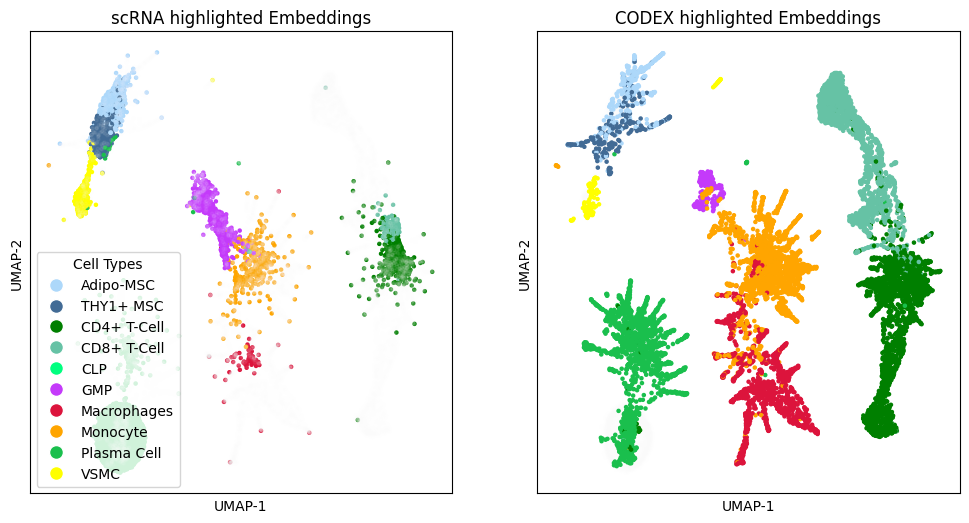

In [50]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
datatype = ['scRNA', 'CODEX']

ct_array1 = rna_adata1[matched_rna,].obs['cell_subtype'].values
ct_array2 = protein_adata[matched_protein].obs['cell_subtype'].values 
ct_array_double = np.concatenate([ct_array1, ct_array2], axis = 0)

colorbar = {
    'Adipo-MSC': np.array([0.67843137, 0.84705882, 0.98039216, 1.]),  # Sky Blue
    'THY1+ MSC': np.array([0.25882353, 0.41960784, 0.58431373, 1.]),  # Darker blue
    'CD4+ T-Cell': np.array([0.0, 0.49803922, 0.0, 1.]),  # Dark green
    'CD8+ T-Cell': np.array([0.4, 0.76078431, 0.64705882, 1.]),  # Lighter green, similar but distinct from CD4+
    'CLP': np.array([0.0, 1.0, 0.49803922, 1.]),  # Brighter green, stands out more
    'GMP': np.array([0.76862745, 0.22745098, 0.98039216, 1.]),  # Red-Purple, distinctive yet in the red spectrum
    'Macrophages': np.array([0.8627451, 0.07843137, 0.23529412, 1.]),  # Dark red
    'Monocyte': np.array([1.0, 0.64705882, 0.0, 1.]),  # Bright red
    'Plasma Cell': np.array([0.1, 0.75098039, 0.3, 1.]),  # Unique shade of green, lighter than CD4+
    'VSMC': np.array([1.0, 1.0, 0.0, 1.])  # Yellow
}
    
color_points = np.array([colorbar[i] for i in ct_array_double])

# dts = np.unique(datatype_array_double)
# color_datatype = ["#FFA500", "#004D99"]
# colorbardt = {t: color_datatype[i] for i, t in enumerate(dts)}
# color_dt = np.array([colorbardt[i] for i in datatype_array_double])

grey = np.array([0.98, 0.98, 0.98, 0.05])[np.newaxis, :]

protein_id = np.array(range(0, len(ct_array1)))
rna_id = np.array(range(len(ct_array1), len(ct_array_double)))
color_points1 = color_points.copy()
color_points1[rna_id, :] = grey
color_points2 = color_points.copy()
color_points2[protein_id, :] = grey

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].scatter(embedding_2[:,0], embedding_2[:,1], color=color_points1, s=5.)
axs[1].scatter(embedding_2[:,0], embedding_2[:,1], color=color_points2, s=5.)
axs[0].set_title('scRNA highlighted Embeddings')
axs[1].set_title('CODEX highlighted Embeddings')
axs[0].set_xlabel('UMAP-1')
axs[0].set_ylabel('UMAP-2')
axs[1].set_xlabel('UMAP-1')
axs[1].set_ylabel('UMAP-2')
for i in axs:
    i.set_facecolor('none')
fig.patch.set_facecolor('none')

legend_celltype = [Line2D([0], [0], marker='o', color='w', label=f'{t}',
                              markerfacecolor=c, markersize=10) for t, c in colorbar.items()]
legend_dt = [Line2D([0], [0], marker='o', color='w', label=f'{t}',
                            markerfacecolor=c, markersize=10) for t, c in colorbardt.items()]

axs[0].legend(handles = legend_celltype, title = "Cell Types", loc = "lower left")
#plt.gca().add_artist(legend1)
#axs[1].legend(handles = legend_celltype, title = "Cell Types", loc = "lower left")

axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_yticks([])
axs[1].set_xticks([])
plt.savefig('/Users/luosanj/Desktop/figures/celLink/umap_bm_cellink_protein_subct.pdf', transparent=True, format = 'pdf')
plt.show()


In [28]:
non_zero_rows = protein_source_ct_array == protein_predict_ct_array

bm_codex_imputed_rnaseq = ad.AnnData(X = protein_aligned_rna[non_zero_rows, :],
                                       obs = protein_adata.obs.iloc[non_zero_rows],
                                       var = pd.DataFrame(rna_adata1.var_names),
                                       )

for key in protein_adata.obsm.keys():
    bm_codex_imputed_rnaseq.obsm[key] = protein_adata.obsm[key].iloc[non_zero_rows, :]
bm_codex_imputed_rnaseq.var_names = bm_codex_imputed_rnaseq.var['Unnamed: 0']

/Users/luosanj/opt/anaconda3/envs/alignment/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Analyze cell-type compositions

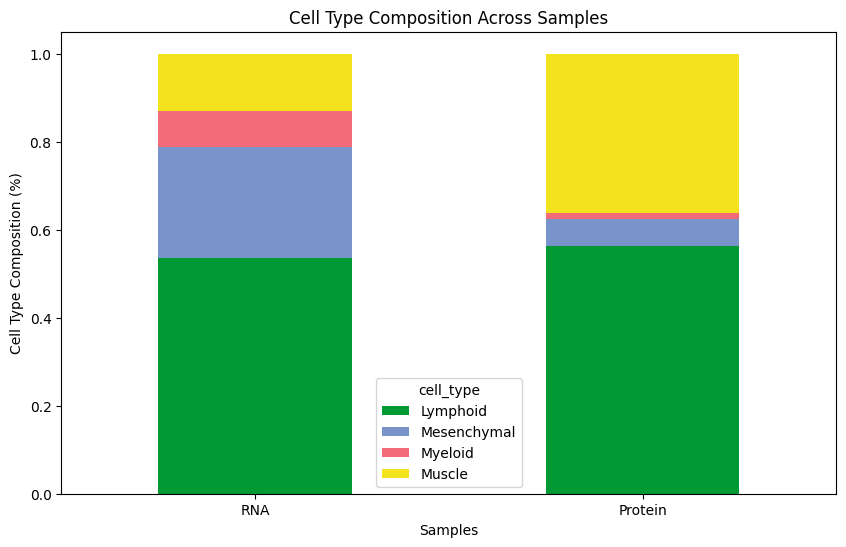

In [100]:
rna_counts = rna_adata1.obs['cell_type'].value_counts()
protein_counts = protein_adata.obs['cell_type'].value_counts()

all_cell_types = sorted(list(set(rna_counts.index).union(set(protein_counts.index))))

# Align RNA and protein counts with the full cell type list, filling missing values with 0
rna_counts = rna_counts.reindex(all_cell_types, fill_value=0)
protein_counts = protein_counts.reindex(all_cell_types, fill_value=0)

df = pd.DataFrame({'RNA' : rna_counts.values/sum(rna_counts.values), 'Protein': protein_counts.values/sum(protein_counts.values)}).T
df.columns = rna_adata1.obs['cell_type'].value_counts().index

# Provided colorbar
colorbar = {'Lymphoid': np.array([0, 0.6, 0.2, 1.0]),
 'Mesenchymal': np.array([0.47265625, 0.58203125, 0.796875  , 1.        ]),
 'Muscle': np.array([0.953125 , 0.890625 , 0.1171875, 1.       ]),
 'Myeloid': np.array([0.9453125 , 0.41796875, 0.46875   , 1.        ])}

# Convert the RGBA arrays to a format that Matplotlib understands
colors = {key: tuple(value) for key, value in colorbar.items()}

# Plotting
ax = df.plot(kind='bar', stacked=True, figsize=(10, 6), color=[colors[cell_type] for cell_type in df.columns])

# Customizing the plot
ax.set_ylabel("Cell Type Composition (%)")
ax.set_xlabel("Samples")
ax.set_title("Cell Type Composition Across Samples")
plt.xticks(rotation=0)
plt.savefig('/Users/luosanj/Desktop/figures/celLink/bone_cell_lineage_percentage.pdf')
# Display the plot
plt.show()

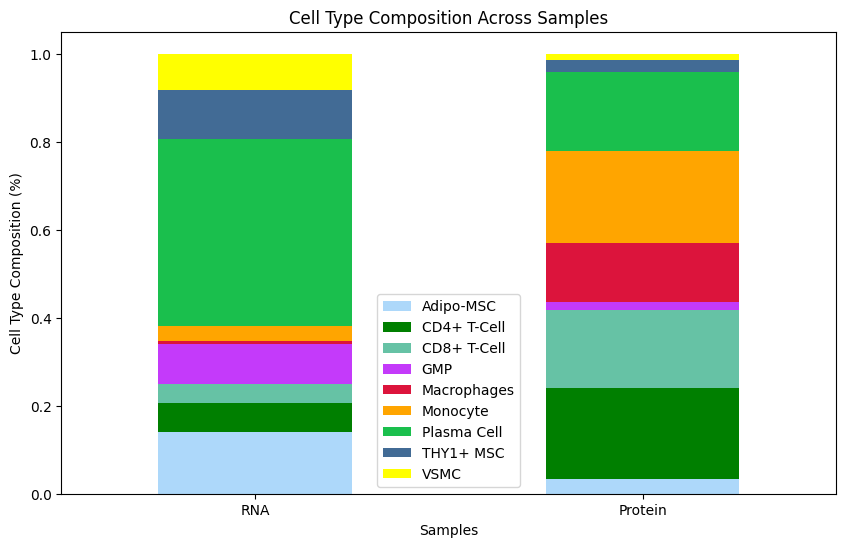

In [101]:
rna_counts = rna_adata1.obs['cell_subtype'].value_counts()
protein_counts = protein_adata.obs['cell_subtype'].value_counts()

all_cell_types = sorted(list(set(rna_counts.index).union(set(protein_counts.index))))

# Align RNA and protein counts with the full cell type list, filling missing values with 0
rna_counts = rna_counts.reindex(all_cell_types, fill_value=0)
protein_counts = protein_counts.reindex(all_cell_types, fill_value=0)

df = pd.DataFrame({'RNA' : rna_counts.values/sum(rna_counts.values), 'Protein': protein_counts.values/sum(protein_counts.values)}).T
df.columns = all_cell_types

# Provided colorbar
colorbar = {
    'Adipo-MSC': np.array([0.67843137, 0.84705882, 0.98039216, 1.]),  # Sky Blue
    'THY1+ MSC': np.array([0.25882353, 0.41960784, 0.58431373, 1.]),  # Darker blue
    'CD4+ T-Cell': np.array([0.0, 0.49803922, 0.0, 1.]),  # Dark green
    'CD8+ T-Cell': np.array([0.4, 0.76078431, 0.64705882, 1.]),  # Lighter green, similar but distinct from CD4+
    'CLP': np.array([0.0, 1.0, 0.49803922, 1.]),  # Brighter green, stands out more
    'GMP': np.array([0.76862745, 0.22745098, 0.98039216, 1.]),  # Red-Purple, distinctive yet in the red spectrum
    'Macrophages': np.array([0.8627451, 0.07843137, 0.23529412, 1.]),  # Dark red
    'Monocyte': np.array([1.0, 0.64705882, 0.0, 1.]),  # Bright red
    'Plasma Cell': np.array([0.1, 0.75098039, 0.3, 1.]),  # Unique shade of green, lighter than CD4+
    'VSMC': np.array([1.0, 1.0, 0.0, 1.])  # Yellow
}

# Convert the RGBA arrays to a format that Matplotlib understands
colors = {key: tuple(value) for key, value in colorbar.items()}

# Plotting
ax = df.plot(kind='bar', stacked=True, figsize=(10, 6), color=[colors[cell_type] for cell_type in df.columns])

# Customizing the plot
ax.set_ylabel("Cell Type Composition (%)")
ax.set_xlabel("Samples")
ax.set_title("Cell Type Composition Across Samples")
plt.xticks(rotation=0)
plt.savefig('/Users/luosanj/Desktop/figures/celLink/bone_cell_subtype_percentage.pdf')
# Display the plot
plt.show()

# Modify the wrong cell type

In [57]:
cd4ID = (rna_source_ct_array == 'CD4+ T-Cell') & (rna_predict_ct_array == 'CD8+ T-Cell')
cd8ID = (rna_source_ct_array == 'CD8+ T-Cell') & (rna_predict_ct_array == 'CD4+ T-Cell')
adipoID = (rna_source_ct_array == 'Adipo-MSC') & (rna_predict_ct_array == 'THY1+ MSC')
thy1ID = (rna_source_ct_array == 'THY1+ MSC') & (rna_predict_ct_array == 'Adipo-MSC')
gmpID = (rna_source_ct_array == 'GMP') & (rna_predict_ct_array == 'Monocyte')
macroID = (rna_source_ct_array == 'Macrophages') & (rna_predict_ct_array == 'Monocyte')

In [58]:
cd4PID = (protein_source_ct_array == 'CD4+ T-Cell') & (protein_predict_ct_array == 'CD8+ T-Cell')
cd8PID = (protein_source_ct_array == 'CD8+ T-Cell') & (protein_predict_ct_array == 'CD4+ T-Cell')
adipoPID = (protein_source_ct_array == 'Adipo-MSC') & (protein_predict_ct_array == 'THY1+ MSC')
thy1PID = (protein_source_ct_array == 'THY1+ MSC') & (protein_predict_ct_array == 'Adipo-MSC')

In [59]:
rr = rna_adata1[rna_id]
pp = protein_adata[protein_id]
rr1 = rna_shared[rna_id]
pp1 = protein_shared[protein_id]
#pp[(pp.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID)]

# CD4+ T & CD8+ T

In [60]:
print(np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8A'].X > 0) & \
    (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8B'].X > 0) & \
(rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD4'].X > 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8A'].X > 0) & \
    (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8B'].X == 0) & \
(rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD4'].X > 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8A'].X == 0) & \
    (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8B'].X > 0) & \
(rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD4'].X > 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8A'].X == 0) & \
    (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8B'].X == 0) & \
(rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD4'].X > 0)))
#

print(np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8A'].X > 0) & \
    (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8B'].X > 0) & \
(rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD4'].X == 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8A'].X > 0) & \
    (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8B'].X == 0) & \
(rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD4'].X == 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8A'].X == 0) & \
    (rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8B'].X > 0) & \
(rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD4'].X == 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8A'].X == 0) & \
(rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD4'].X == 0) & \
(rr[(rr.obs['cell_subtype'] == 'CD4+ T-Cell') & (cd4ID), 'CD8B'].X == 0)))

1
2
0
103
111
47
23
239


In [62]:
111+47+23+239

420

In [158]:
import plotly.graph_objects as go

# Example data for a sunburst chart
labels = ['T Cells', 'CD4+', 'CD4-', 
          'CD4+ CD8A+ CD8B+', 'CD4+ CD8A+ CD8B-', 'CD4+ CD8A- CD8B+', 'CD4+ CD8A- CD8B-', 
          'CD4- CD8A+ CD8B+', 'CD4- CD8A+ CD8B-', 'CD4- CD8A- CD8B+', 'CD4- CD8A- CD8B-']
parents = ['', 'T Cells', 'T Cells', 
           'CD4+', 'CD4+', 'CD4+', 'CD4+', 
           'CD4-', 'CD4-', 'CD4-', 'CD4-']
values = [546, 123, 423, 1, 2, 0, 120, 111, 47, 23, 242]

# Create sunburst chart
fig = go.Figure(go.Sunburst(
    labels=labels,
    parents=parents,
    values=values,
    branchvalues="total"
))

# Update layout for larger figure size
fig.update_layout(
    title='Hierarchical Representation of CD4 and CD8 Status in T Cells',
    width=800,  # Adjust the width
    height=800  # Adjust the height
)

fig.show()


In [60]:
import plotly.graph_objects as go

# Example data for a sunburst chart
labels = ['T Cells', 'CD4+', 'CD4-', 
          'CD4+ CD8A+ CD8B+', 'CD4+ CD8A+ CD8B-', 'CD4+ CD8A- CD8B+', 'CD4+ CD8A- CD8B-', 
          'CD4- CD8A+ CD8B+', 'CD4- CD8A+ CD8B-', 'CD4- CD8A- CD8B+', 'CD4- CD8A- CD8B-']
parents = ['', 'T Cells', 'T Cells', 
           'CD4+', 'CD4+', 'CD4+', 'CD4+', 
           'CD4-', 'CD4-', 'CD4-', 'CD4-']
values = [445, 89, 356, 1, 1, 0, 87, 112, 45, 22, 177]

# Create sunburst chart
fig = go.Figure(go.Sunburst(
    labels=labels,
    parents=parents,
    values=values,
    branchvalues="total"
))

# Update layout for larger figure size
fig.update_layout(
    title='Hierarchical Representation of CD4 and CD8 Status in T Cells',
    width=800,  # Adjust the width
    height=800  # Adjust the height
)

fig.show()


# Adipo-msc & Thy1-msc 

In [63]:
print(np.sum(rr[(rr.obs['cell_subtype'] == 'Adipo-MSC') & (adipoID), 'THY1'].X == 0))
print(np.sum(rr[(rr.obs['cell_subtype'] == 'Adipo-MSC') & (adipoID), 'THY1'].X > 0))

91
267


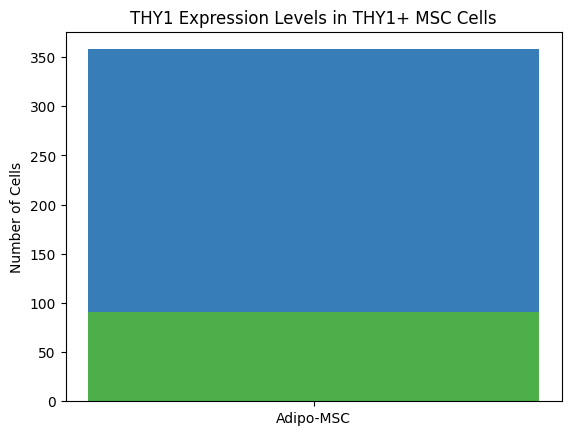

In [64]:
# Data for the stacked bar plot
expression_levels = ['THY1 == 0', 'THY1 > 0']
counts = [91, 267]  # Replace with your counts

# Create stacked bar plot
fig, ax = plt.subplots()

ax.bar('Adipo-MSC', counts[0], label='THY1 == 0', color='#4daf4a')
ax.bar('Adipo-MSC', counts[1], bottom=counts[0], label='THY1 > 0', color='#377eb8')

# Add labels and title
ax.set_ylabel('Number of Cells')
ax.set_title('THY1 Expression Levels in THY1+ MSC Cells')
#ax.legend()

plt.show()

In [65]:
print(np.mean(pp[(pp.obs['cell_subtype'] == 'Adipo-MSC') & (adipoPID), 'CD90'].X))
print(np.mean(pp[(pp.obs['cell_subtype'] == 'Adipo-MSC'), 'CD90'].X))
print(np.mean(pp[(pp.obs['cell_subtype'] == 'THY1+ MSC'), 'CD90'].X))

0.7681434
0.65078217
1.3339897


In [66]:
print(np.sum(rr[(rr.obs['cell_subtype'] == 'THY1+ MSC') & (thy1ID), 'THY1'].X == 0))
print(np.sum(rr[(rr.obs['cell_subtype'] == 'THY1+ MSC') & (thy1ID), 'THY1'].X > 0))

187
128


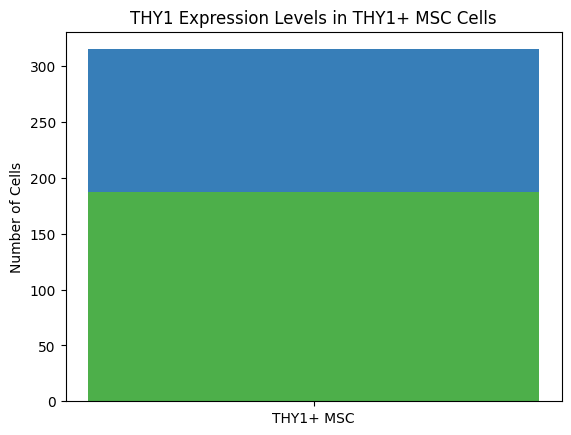

In [70]:
# Data for the stacked bar plot
expression_levels = ['THY1 == 0', 'THY1 > 0']
counts = [187, 128]  # Replace with your counts

# Create stacked bar plot
fig, ax = plt.subplots()

ax.bar('THY1+ MSC', counts[0], label='THY1 == 0', color='#4daf4a')
ax.bar('THY1+ MSC', counts[1], bottom=counts[0], label='THY1 > 0', color='#377eb8')

# Add labels and title
ax.set_ylabel('Number of Cells')
ax.set_title('THY1 Expression Levels in THY1+ MSC Cells')
#ax.legend()

plt.show()

# Monocyte, Macrophage, and GMP

In [169]:
print(np.sum(rr[(rr.obs['cell_subtype'] == 'Macrophages') & (adipoID), 'THY1'].X == 0))
print(np.sum(rr[(rr.obs['cell_subtype'] == 'Macrophages') & (adipoID), 'THY1'].X > 0))

0
0


In [69]:
print(np.sum((rr[(rr.obs['cell_subtype'] == 'GMP') & (gmpID), 'CD34'].X > 0) & \
(rr[(rr.obs['cell_subtype'] == 'GMP') & (gmpID), 'CD38'].X > 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'GMP') & (gmpID), 'CD34'].X > 0) & \
(rr[(rr.obs['cell_subtype'] == 'GMP') & (gmpID), 'CD38'].X == 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'GMP') & (gmpID), 'CD34'].X == 0) & \
(rr[(rr.obs['cell_subtype'] == 'GMP') & (gmpID), 'CD38'].X > 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'GMP') & (gmpID), 'CD34'].X == 0) & \
(rr[(rr.obs['cell_subtype'] == 'GMP') & (gmpID), 'CD38'].X == 0)))

120
13
403
126


In [71]:
print(np.sum((rr[(rr.obs['cell_subtype'] == 'Monocyte') , 'CD34'].X == 0) & \
(rr[(rr.obs['cell_subtype'] == 'Monocyte'), 'CD38'].X > 0)))

111


In [72]:
print(np.sum(rr[(rr.obs['cell_subtype'] == 'Monocyte'), 'CD14'].X > 0))
print(np.sum(rr[(rr.obs['cell_subtype'] == 'Monocyte'), 'CD14'].X == 0))
print(np.sum(rr[(rr.obs['cell_subtype'] == 'Monocyte'), 'CD163'].X > 0))

270
64
153


In [73]:
print(np.sum(rr[(rr.obs['cell_subtype'] == 'Macrophages') & macroID, 'CD163'].X == 0))
print(np.sum(rr[(rr.obs['cell_subtype'] == 'Macrophages') & macroID, 'CD163'].X > 0))
print(np.sum(rr[(rr.obs['cell_subtype'] == 'Macrophages') & macroID, 'CD14'].X > 0))

25
0
4


In [74]:
print(np.sum((rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'CD163'].X > 0) & \
(rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'CD68'].X > 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'CD163'].X > 0) & \
(rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'CD68'].X == 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'CD163'].X == 0) & \
(rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'CD68'].X > 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'CD163'].X == 0) & \
    (rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'HLA-DRA'].X > 0)& \
(rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'CD68'].X > 0)))

print(np.sum((rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'CD163'].X == 0) & \
(rr[(rr.obs['cell_subtype'] == 'Macrophages') & (macroID), 'CD68'].X == 0)))

0
0
16
13
9


In [144]:
print(np.mean(rr[(rr.obs['cell_subtype'] == 'Monocyte'), 'CD163'].X))
print(np.mean(rr[(rr.obs['cell_subtype'] == 'Monocyte'), 'CD68'].X))
print(np.mean(rr[(rr.obs['cell_subtype'] == 'Monocyte'), 'CD14'].X))
print(np.mean(rr[(rr.obs['cell_subtype'] == 'Macrophages'), 'CD163'].X))
print(np.mean(rr[(rr.obs['cell_subtype'] == 'Macrophages'), 'CD68'].X))
print(np.mean(rr[(rr.obs['cell_subtype'] == 'Macrophages'), 'CD14'].X))

0.27172196
0.52885413
0.596969
0.43439707
1.1342174
0.37734252


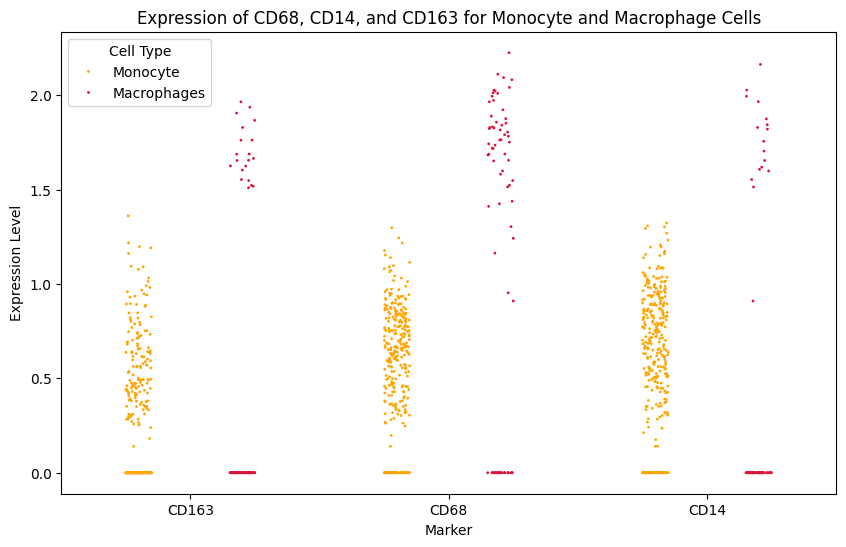

In [75]:
monocyte_cd163 = rr[(rr.obs['cell_subtype'] == 'Monocyte'), 'CD163'].X.flatten()
monocyte_cd68 = rr[(rr.obs['cell_subtype'] == 'Monocyte'), 'CD68'].X.flatten()
monocyte_cd14 = rr[(rr.obs['cell_subtype'] == 'Monocyte'), 'CD14'].X.flatten()

macrophage_cd163 = rr[(rr.obs['cell_subtype'] == 'Macrophages'), 'CD163'].X.flatten()
macrophage_cd68 = rr[(rr.obs['cell_subtype'] == 'Macrophages'), 'CD68'].X.flatten()
macrophage_cd14 = rr[(rr.obs['cell_subtype'] == 'Macrophages'), 'CD14'].X.flatten()

# Create a DataFrame for seaborn
data = pd.DataFrame({
    'Expression': np.concatenate([monocyte_cd163, monocyte_cd68, monocyte_cd14, macrophage_cd163, macrophage_cd68, macrophage_cd14]),
    'Marker': ['CD163'] * len(monocyte_cd163) + ['CD68'] * len(monocyte_cd68) + ['CD14'] * len(monocyte_cd14) +
              ['CD163'] * len(macrophage_cd163) + ['CD68'] * len(macrophage_cd68) + ['CD14'] * len(macrophage_cd14),
    'Cell Type': ['Monocyte'] * (len(monocyte_cd163) + len(monocyte_cd68) + len(monocyte_cd14)) +
                 ['Macrophages'] * (len(macrophage_cd163) + len(macrophage_cd68) + len(macrophage_cd14))
})

# Plot the box plot using seaborn
custom_palette = {
    'Macrophages': np.array([0.8627451, 0.07843137, 0.23529412, 1.]),  # Dark red
    'Monocyte': np.array([1.0, 0.64705882, 0.0, 1.])  # Orange
}

# Plot the swarm plot using seaborn with custom colors
plt.figure(figsize=(10, 6))
sns.stripplot(x='Marker', y='Expression', hue='Cell Type', data=data, palette=custom_palette, dodge=True, size=2)

# Customize the plot
plt.title('Expression of CD68, CD14, and CD163 for Monocyte and Macrophage Cells')
plt.xlabel('Marker')
plt.ylabel('Expression Level')
plt.savefig('/Users/luosanj/Desktop/figures/celLink/rna_macro_mono.pdf')
plt.show()

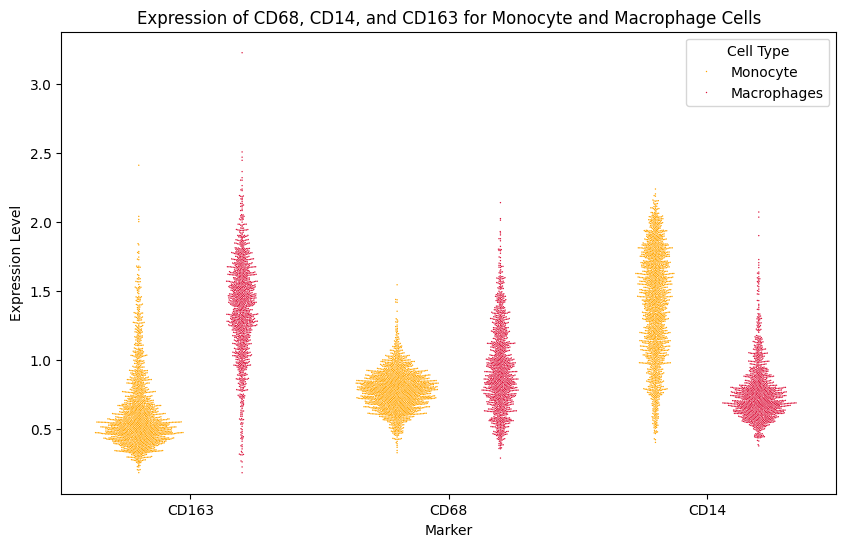

In [76]:
monocyte_cd163 = pp[(pp.obs['cell_subtype'] == 'Monocyte'), 'CD163'].X.flatten()
monocyte_cd68 = pp[(pp.obs['cell_subtype'] == 'Monocyte'), 'CD68'].X.flatten()
monocyte_cd14 = pp[(pp.obs['cell_subtype'] == 'Monocyte'), 'CD14'].X.flatten()

macrophage_cd163 = pp[(pp.obs['cell_subtype'] == 'Macrophages'), 'CD163'].X.flatten()
macrophage_cd68 = pp[(pp.obs['cell_subtype'] == 'Macrophages'), 'CD68'].X.flatten()
macrophage_cd14 = pp[(pp.obs['cell_subtype'] == 'Macrophages'), 'CD14'].X.flatten()

# Create a DataFrame for seaborn
data = pd.DataFrame({
    'Expression': np.concatenate([monocyte_cd163, monocyte_cd68, monocyte_cd14, macrophage_cd163, macrophage_cd68, macrophage_cd14]),
    'Marker': ['CD163'] * len(monocyte_cd163) + ['CD68'] * len(monocyte_cd68) + ['CD14'] * len(monocyte_cd14) +
              ['CD163'] * len(macrophage_cd163) + ['CD68'] * len(macrophage_cd68) + ['CD14'] * len(macrophage_cd14),
    'Cell Type': ['Monocyte'] * (len(monocyte_cd163) + len(monocyte_cd68) + len(monocyte_cd14)) +
                 ['Macrophages'] * (len(macrophage_cd163) + len(macrophage_cd68) + len(macrophage_cd14))
})

# Plot the box plot using seaborn
custom_palette = {
    'Macrophages': np.array([0.8627451, 0.07843137, 0.23529412, 1.]),  # Dark red
    'Monocyte': np.array([1.0, 0.64705882, 0.0, 1.])  # Orange
}

plt.figure(figsize=(10, 6))
sns.swarmplot(x='Marker', y='Expression', hue='Cell Type', data=data, palette = custom_palette, dodge=True, size=1) 

# Customize the plot
plt.title('Expression of CD68, CD14, and CD163 for Monocyte and Macrophage Cells')
plt.xlabel('Marker')
plt.ylabel('Expression Level')
plt.savefig('/Users/luosanj/Desktop/figures/celLink/protein_macro_mono.pdf')
plt.show()